# _Trial 9: Creating a DL Model for Atelectasis_

Focus: Train Model on Multiple Sample Sets of Data

In [37]:
from capstone import data, uonesetup
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [20]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [3]:
# take 5% of data with a seed of 1
train_df, valid_df = data.data_processing(path, 'Atelectasis', 1, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(11576, 2)

Validation shape
(234, 2)


In [4]:
train_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/train/patient00003/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00015/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00015/study2/...,-1.0
3,CheXpert-v1.0-small/train/patient00028/study1/...,-1.0
4,CheXpert-v1.0-small/train/patient00028/study2/...,1.0


In [5]:
valid_df.head()

,Path,Atelectasis
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# Convert `-1` Values to `1` -- _U-Ones_ Uncertainty Model

In [6]:
train_df['Atelectasis'].value_counts(normalize=True)

 0.0    0.698601
 1.0    0.152903
-1.0    0.148497
Name: Atelectasis, dtype: float64

In [7]:
# reassign -1 to 1 
train_df = train_df.replace(to_replace=-1.0, value=1)
train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)

In [8]:
train_df['Atelectasis'].value_counts(normalize=True)

0    0.698601
1    0.301399
Name: Atelectasis, dtype: float64

In [9]:
train_df.shape

(11576, 2)

In [10]:
from sklearn.metrics import roc_auc_score

class AUC(Callback):
    "AUC score"
    def __init__(self):
        pass
    
    def on_epoch_begin(self, **kwargs): 
        self.outputs = []
        self.targets = []

    def on_batch_end(self, last_output, last_target, **kwargs):
        "expects binary output with data.c=2 "
        self.outputs += list(to_np(last_output)[:, 1])
        self.targets += list(to_np(last_target))

    def on_epoch_end(self, last_metrics, **kwargs): 
        return {'last_metrics': last_metrics + [roc_auc_score(self.targets, self.outputs)]}

auc = AUC()

In [11]:
tfms = get_transforms(do_flip=False, flip_vert=False)

In [12]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [13]:
src = src.split_by_rand_pct(0.1)

In [67]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=64
else:           
    bs=32
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=32, have 6940MB of GPU RAM free


## Create data for Model

In [15]:
data = (src.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [16]:
learn9 = cnn_learner(data=data, base_arch=models.densenet121, metrics=[accuracy, auc], pretrained=True,
                      callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-06


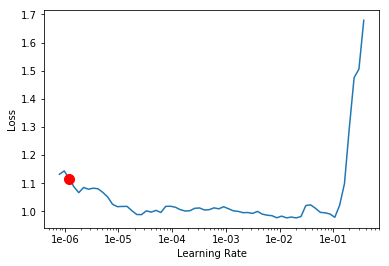

In [17]:
learn9.lr_find(start_lr=1e-7, end_lr=100)
learn9.recorder.plot(suggestion=True)

# Rd. 1 Training

In [18]:
lr = learn9.recorder.min_grad_lr

epoch,train_loss,valid_loss,accuracy,auc,time
0,1.017044,0.733997,0.617113,0.501820,04:03
1,0.975648,0.719411,0.617977,0.503006,04:01
2,0.936226,0.710205,0.614520,0.507276,04:01
3,0.974061,0.715839,0.603284,0.511839,04:01
4,0.975933,0.707182,0.626621,0.505980,04:01


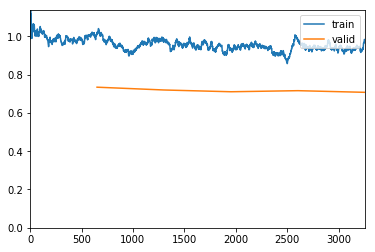

In [19]:
learn9.fit_one_cycle(5, lr)

In [21]:
learn9.save('learn9-stage-1-rn121')

# Rd. 2 Training

In [23]:
learn9.unfreeze() # sets every layer group to trainable

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.16E-07


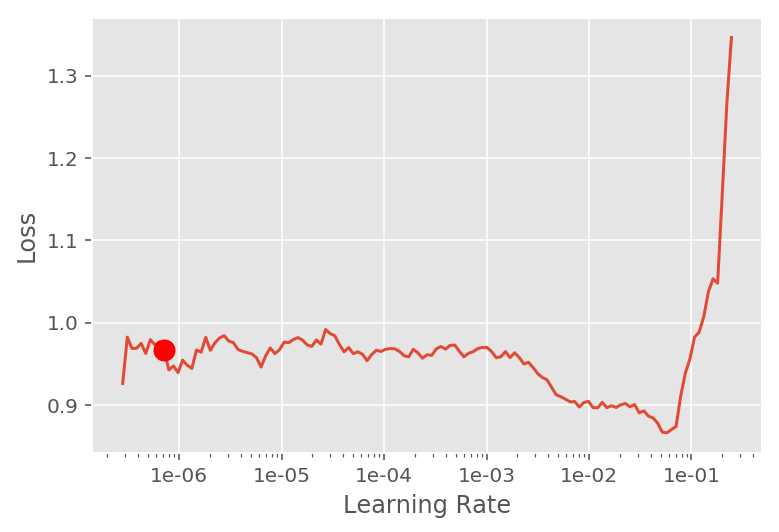

In [24]:
learn9.lr_find(start_lr=1e-7, end_lr=100, num_it=200)
learn9.recorder.plot(suggestion=True)

In [26]:
lr = (1e-03 + 1e-02) / 2
lr

0.0055

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.683982,1.202234,0.697493,0.530551,05:14
1,0.654757,0.614132,0.696629,0.558212,05:13
2,0.604803,0.608216,0.697493,0.570982,05:13


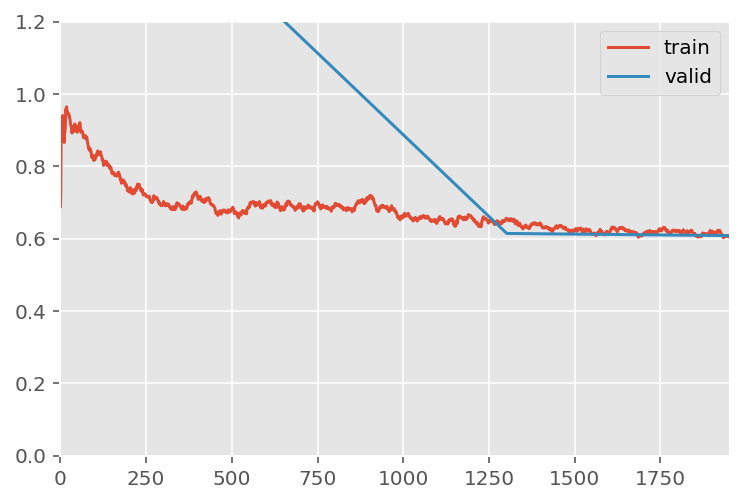

In [27]:
learn9.fit_one_cycle(3, lr)

In [29]:
learn9.save('learn9-rd-2-dn121')

# Rd. 3 Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.13E-07


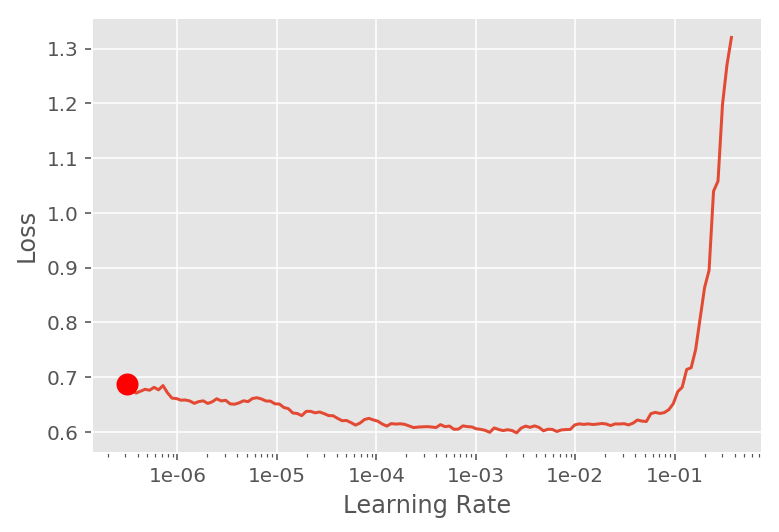

In [30]:
learn9.lr_find(start_lr=1e-7, end_lr=100, num_it=200)
learn9.recorder.plot(suggestion=True)

In [32]:
lr = (1e-05 + 1e-04) / 2
lr

5.5e-05

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.614944,0.607285,0.697493,0.574665,05:13
1,0.604138,0.606543,0.697493,0.577961,05:13
2,0.603333,0.606630,0.697493,0.577001,05:13


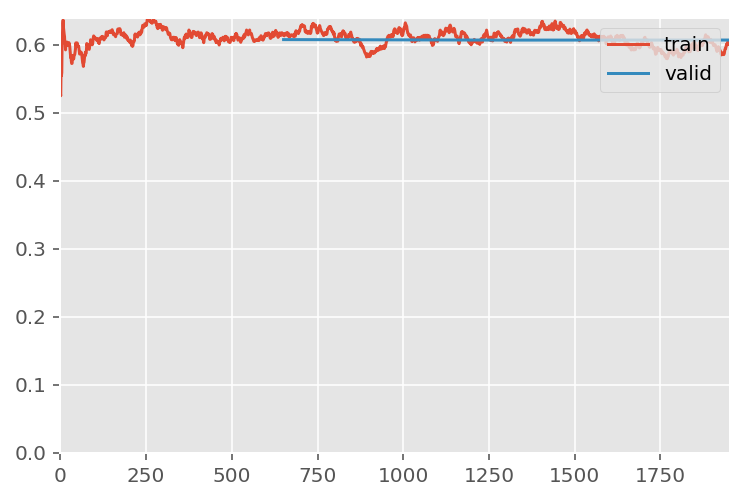

In [33]:
learn9.fit_one_cycle(3, slice(lr, lr/5))

In [35]:
learn9.save('learn9-rd-3-dn121')

# Feed In New Data Set Sample (w/ different random seed)

In [38]:
# take 5% of data with a seed of 7
train_df2, valid_df2 = data.data_processing(path, 'Atelectasis', 7, 0.05);

(223414, 19)
(234, 19)
Extracted Patient ID from Path column and created new column named Patient_id
Created function named seed_data to set seed for sample data
Seeded data.
Created sample dataframe with input seed.
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
Atelectasis
Training shape
(11029, 2)

Validation shape
(234, 2)


In [39]:
# reassign -1 to 1 
train_df2 = train_df2.replace(to_replace=-1.0, value=1)
train_df2['Atelectasis'] = train_df2['Atelectasis'].astype(int)

In [40]:
train_df2['Atelectasis'].value_counts(normalize=True)

0    0.704416
1    0.295584
Name: Atelectasis, dtype: float64

In [41]:
train_df2.shape

(11029, 2)

In [42]:
src2 = (ImageList.from_df(df=train_df2, path=path, folder='.', suffix=''))

In [43]:
src2 = src2.split_by_rand_pct(0.1)

In [44]:
data2 = (src2.label_from_df(cols='Atelectasis')
        .transform(tfms, size=320)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [45]:
learn9.freeze()

### Reassign Data to New Sample

In [47]:
# replace 1st sample data set with 2nd sample data set
learn9.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 320, 320])

# Rd. 4 Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.13E-07


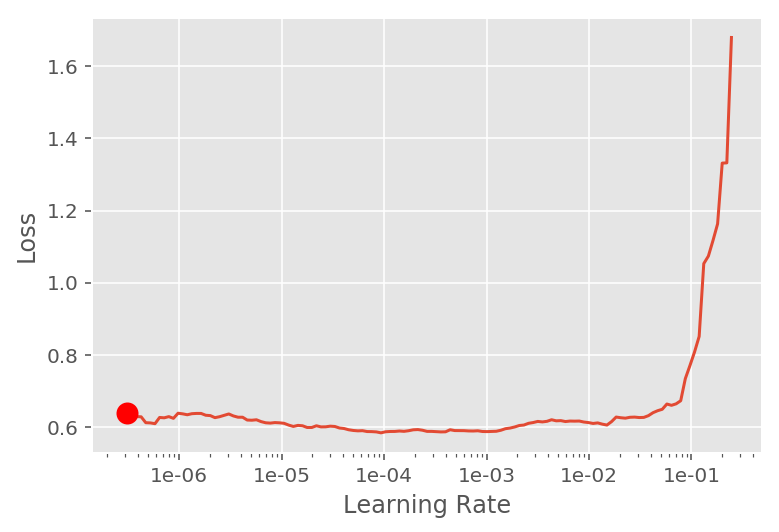

In [48]:
learn9.lr_find(start_lr=1e-7, end_lr=100, num_it=200)
learn9.recorder.plot(suggestion=True)

In [53]:
lr = (1e-06 + 1e-04) / 2
lr

5.05e-05

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.609255,0.599647,0.695100,0.602698,03:52
1,0.605462,0.599583,0.695100,0.602993,03:48
2,0.603146,0.599823,0.695100,0.603728,03:48
3,0.594456,0.599792,0.695100,0.603763,03:48
4,0.622110,0.599629,0.695100,0.602010,03:48


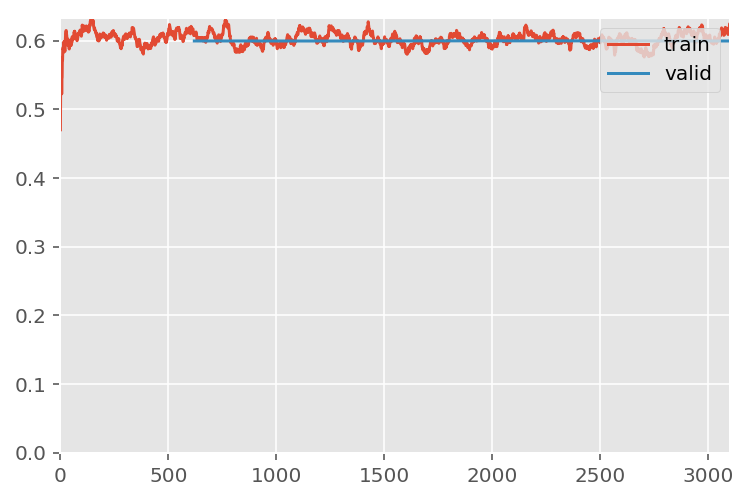

In [54]:
learn9.fit_one_cycle(5, slice(lr))

In [55]:
learn9.save('learn9-rd-4-dn121')

# Rd. 5 Training

In [56]:
learn9.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-07


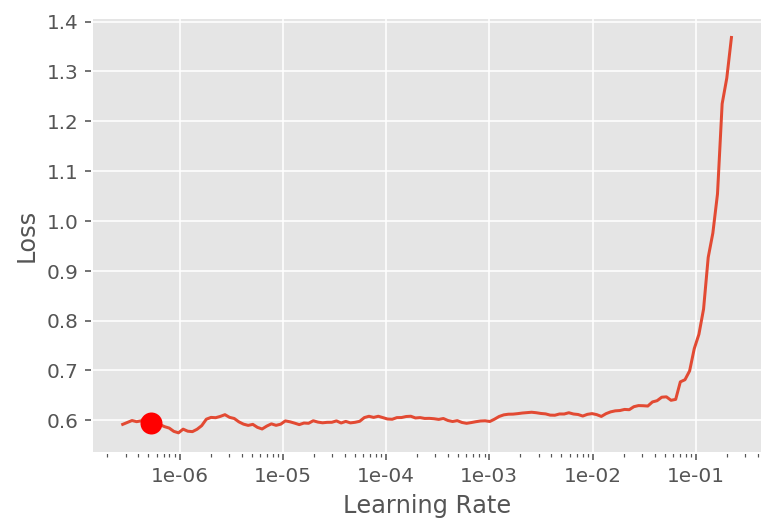

In [63]:
learn9.lr_find(start_lr=1e-7, end_lr=100, num_it=200)
learn9.recorder.plot(suggestion=True)

In [64]:
# use faster learning rate that showed most impressive improvement from rd. 2 training
lr = (1e-03 + 1e-02) / 2
lr

0.0055

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.633001,0.619838,0.696007,0.575096,04:58
1,0.609363,0.606642,0.695100,0.570725,04:58
2,0.600123,0.595786,0.695100,0.591990,04:57


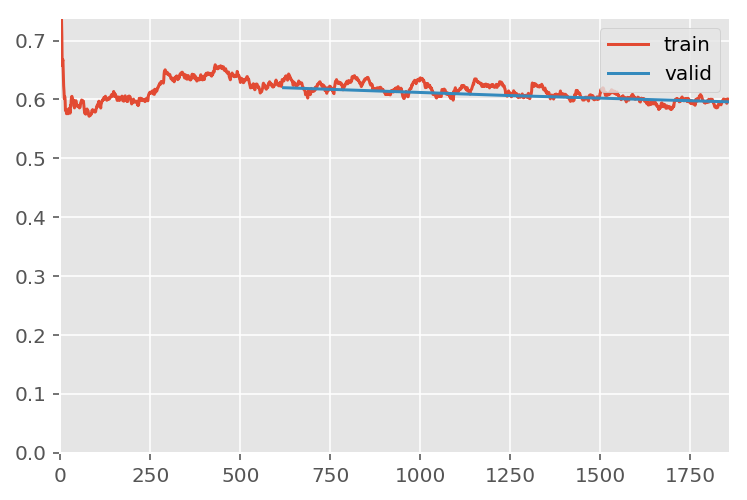

In [65]:
learn9.fit_one_cycle(3, lr)

# Rd. 6 Training 

epoch,train_loss,valid_loss,accuracy,auc,time
0,0.605103,0.597598,0.695100,0.557985,04:58
1,0.615601,0.594750,0.695100,0.587969,04:58
2,0.578137,0.594553,0.695100,0.596450,04:58


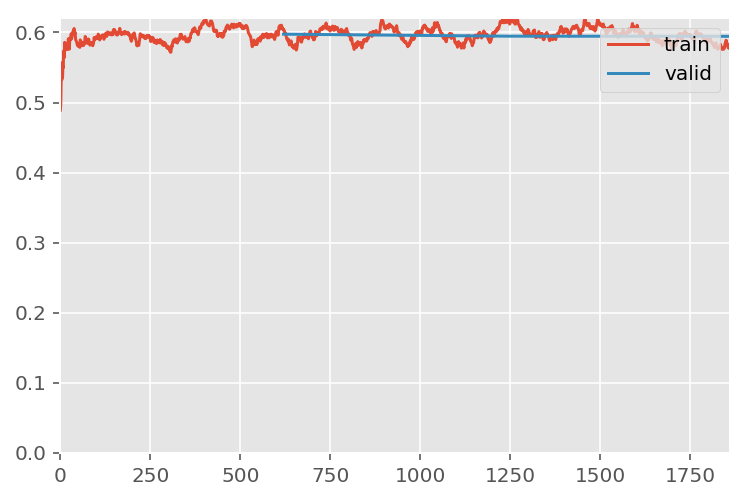

In [66]:
learn9.fit_one_cycle(3, slice(1e-6, lr/5))

In [68]:
learn9.save('learn9-rd-6-dn121')